In [ ]:
from fastai.vision.all import *
from fastai.data.all import *

In [ ]:
import torch

In [ ]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

In [ ]:
# !kaggle competitions download -c iwildcam-2020-fgvc7 -p /storage/iwildcam-2020-fgvc7

In [ ]:
# !unzip -q /storage/iwildcam-2020-fgvc7/iwildcam-2020-fgvc7.zip -d /storage/iwildcam-2020-fgvc7

In [ ]:
from pathlib import Path
input_path = Path('/storage/iwildcam-2020-fgvc7')
my_data_path = Path('/storage/my-iwildcam2020-data')


In [ ]:
def get_verified_image_files(path):
    
    if Path(my_data_path/'image_paths.pkl').exists():
        with open(my_data_path/'image_paths.pkl', 'rb') as f:
            files = pickle.load(f)
    else:
        files = get_image_files(path)
        with open(my_data_path/'image_paths.pkl', 'wb') as f:
            pickle.dump(files, f)
        
    blacklist = []
    
    if (path/'failed_imgs_lst.pkl').exists():
        with open(path/'failed_imgs_lst.pkl', 'rb') as f:
            blacklist = pickle.load(f)
    else:
        blacklist = verify_images(files)
        with open(path/'failed_imgs_lst.pkl', 'wb') as f:
            pickle.dump(blacklist, f)


    return list(set(files).difference(blacklist))


In [ ]:
def get_annotations_iwildcam(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    
    annot_dict = json.load(open(fname))
    id2images, id2cats = {}, {}
    classes = {o['id']:o['name'] for o in annot_dict['categories']}
    id2cats = {o['image_id']:o['category_id'] for o in annot_dict['annotations']}        
    id2images = {o['id']:o['file_name'] for o in annot_dict['images']}
                                     
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [id2cats[k] for k in ids]


In [ ]:
# images, lbls = get_annotations_iwildcam(input_path/'iwildcam2020_train_annotations.json')
# img2lbls = dict(zip(images, lbls))

In [ ]:
def get_label_counts(img_labels):
    label_counts = {}
    
    lbls_list = img_labels
    classes = list(set(lbls_list))

    for clss in classes:
        imgs_class = [i for i, v in enumerate(lbls_list) if v == clss]
        label_counts[clss] = len(imgs_class)
        
    return label_counts

In [ ]:
def get_freq_label_images(path, min_count=2):
    image_files = get_verified_image_files(path)
    freq_image_files = []
    images, lbls = get_annotations_iwildcam(input_path/'iwildcam2020_train_annotations.json')
    img2lbls = dict(zip(images, lbls))
    
    label_counts = get_label_counts(lbls)
    
    for img in image_files:
        lbl = img2lbls[img.name][0]
        if label_counts[lbl] >= min_count:
            freq_image_files.append(img)
    
    return freq_image_files


In [ ]:
def make_train_df(annotation_file, outputs_path, min_cat_count=2):
    images, lbls = get_annotations_iwildcam(annotation_file)
    img2lbls = dict(zip(images, lbls))
    
    if not outputs_path.exists():
        outputs_path.mkdir()
        
    label_counts = get_label_counts(lbls)
    if Path(outputs_path/'image_paths.pkl').exists():
        with open(outputs_path/'image_paths.pkl', 'rb') as f:
            image_files = pickle.load(f)
    else:
        image_files = get_image_files(input_path/'train')
        with open(outputs_path/'image_paths.pkl', 'wb') as f:
            pickle.dump(image_files, f)

    if (outputs_path/'failed_imgs_lst.pkl').exists():
        with open(outputs_path/'failed_imgs_lst.pkl', 'rb') as f:
            blacklist = pickle.load(f)
    else:
        blacklist = verify_images(image_files)
        with open(outputs_path/'failed_imgs_lst.pkl', 'wb') as f:
            pickle.dump(blacklist, f)

    image_files = set(image_files).difference(blacklist)
    
    rare_label_images = []
    for img in image_files:
        lbl = img2lbls[img.name]
        if label_counts[lbl] < min_cat_count:
            rare_label_images.append(img)
            
    image_files = image_files.difference(rare_label_images)
    
    train_dict = {'file': [], 'category': []}
    for img in image_files:
        train_dict['file'].append(img.name)
        train_dict['category'].append(img2lbls[img.name])
        
    return pd.DataFrame(train_dict)
    

    

In [ ]:
train_df = make_train_df(input_path/'iwildcam2020_train_annotations.json',
                        my_data_path, min_cat_count=5)

In [ ]:
len(train_df)

174851

In [ ]:
train_df.head()

,file,category
0,8f2f86c8-21bc-11ea-a13a-137349068a90.jpg,404
1,9599d5d6-21bc-11ea-a13a-137349068a90.jpg,0
2,8c42b9d0-21bc-11ea-a13a-137349068a90.jpg,317
3,86e5d8b4-21bc-11ea-a13a-137349068a90.jpg,0
4,89feec48-21bc-11ea-a13a-137349068a90.jpg,90


In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(0, pref=input_path/"train"),
    get_y=ColReader(1),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224),
    splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [ ]:
dls = db.dataloaders(train_df)

In [ ]:
def get_valid_test_images(path, outputs_path):
    image_files = get_image_files(path)
    
    if (outputs_path/'failed_test_imgs_lst.pkl').exists():
        with open(outputs_path/'failed_test_imgs_lst.pkl', 'rb') as f:
            blacklist = pickle.load(f)
    else:
        blacklist = verify_images(image_files)
        with open(outputs_path/'failed_test_imgs_lst.pkl', 'wb') as f:
            pickle.dump(blacklist, f)

    image_files = set(image_files).difference(blacklist)
    
    return list(image_files)

test_images = get_valid_test_images(input_path/'test', my_data_path)

In [ ]:
test_images[:10]

In [ ]:
dls.show_batch(max_n=10)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.002511886414140463)

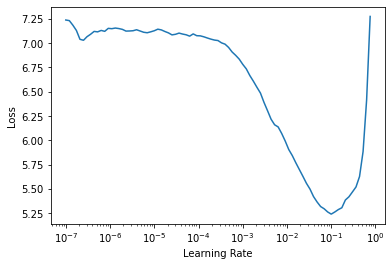

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(2, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.375350,1.086383,0.292679,31:55


epoch,train_loss,valid_loss,error_rate,time
0,0.883280,0.716304,0.199571,32:29
1,0.668465,0.529878,0.150558,32:59


In [ ]:
learn.export()

In [ ]:
# path = Path()
# learn = load_learner(path/'export.pkl')

In [ ]:
img_idx = 2201
pred,pred_idx,probs = learn.predict(test_images[img_idx])
img = PILImage.create(test_images[img_idx])

img.show()
print(f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}')

In [ ]:
dl = learn.dls.test_dl(test_images)
preds_batch, _, cat_ids = learn.get_preds(dl=dl, with_decoded=True)

In [ ]:
cat_ids[:100]

In [ ]:
img_names = [img.stem for img in test_images[:100]]

In [ ]:
test_results = pd.DataFrame({'Id': img_names, 'Category': cat_ids})

In [ ]:
!kaggle competitions submit -c iwildcam-2020-fgvc7 -f "test_results.csv" -m "2nd try"